###  This code will read in the full datacube and run k-means clustering

It will then analyze the clusters

In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import os
import re
import numpy as np
import matplotlib
class MidpointNormalize(matplotlib.colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

In [2]:
# Need to pull all of the names that exist
#print(os.listdir())
# This will yield a tuple for each subdirectory. Ths first entry in the 3-tuple is a directory name, so:

plates = [x[2] for x in os.walk('/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_derotated_and_rescaled/')][0]
print('Searching through this directory for all of the existing ifus', plates)



existing_plateifus=[]

for j in range(len(plates)):
    ifu = re.split('.fits',plates[j])[0]
    existing_plateifus.append(str(ifu))
print(existing_plateifus)
print('this is how many galaxies you are working with', len(existing_plateifus))
# Now you need to construct plateifu names of what exists

Searching through this directory for all of the existing ifus ['8985-12701.fits', '9000-12703.fits', '9496-12703.fits', '9001-6104.fits', '8977-6103.fits', '8145-3704.fits', '8723-6104.fits', '10510-12701.fits', '7991-12704.fits', '8145-12704.fits', '8979-6101.fits', '8588-3704.fits', '8313-6102.fits', '8143-3704.fits', '8948-12701.fits', '8714-1902.fits', '10519-12704.fits', '8323-6101.fits', '8465-9102.fits', '8453-12701.fits', '9499-12704.fits', '7991-12702.fits', '8979-12704.fits', '8941-9102.fits', '9892-6101.fits', '8725-6103.fits', '9499-12703.fits', '8323-3703.fits', '8977-6104.fits', '9869-12702.fits', '8984-12703.fits', '9038-12702.fits', '8341-12704.fits', '8946-1902.fits', '9497-1901.fits', '8313-12703.fits', '8323-9101.fits', '8465-6102.fits', '10510-12705.fits', '8322-1901.fits', '8322-6102.fits', '8947-6104.fits', '7990-12705.fits', '8454-12703.fits', '9036-3701.fits', '8341-6102.fits', '8315-12702.fits', '9868-1901.fits', '7962-12704.fits', '8453-12705.fits', '9491-6101

In [4]:
# Now you need to go through and pick out whatever data you want
# Let's say for example that you want to work with the stellar velocity and stellar velocity dispersion maps
file_ex = fits.open('kin_maps_derotated_and_rescaled/'+str(existing_plateifus[0])+'.fits')
length_cube = np.shape(file_ex[1].data)[0]**2
shape = int(np.sqrt(length_cube))

#was 13 and 14

map_ml_stel_vel = np.zeros((len(plates), length_cube))
map_ml_stel_disp = np.zeros((len(plates), length_cube))
# The below cube contains everything, all of the velocity and velocity dispersion maps
map_ml_all_stel = np.zeros((len(plates), 2*length_cube))
for j in range(len(plates)):
    file = fits.open('kin_maps_derotated_and_rescaled/'+str(existing_plateifus[j])+'.fits')
    
    '''plt.clf()
    plt.imshow(file[1].data, cmap='RdBu_r')
    plt.colorbar()
    plt.title(str(file[0].header['EXT0']))
    plt.show()
    
    plt.clf()
    plt.imshow(file[5].data, cmap='RdBu_r')
    plt.colorbar()
    plt.title(str(file[0].header['EXT4']))
    plt.show()
    
    plt.clf()
    plt.imshow(abs(file[5].data/file[1].data),  vmax=20)
    plt.colorbar()
    plt.title(str(file[0].header['EXT4']))
    plt.show()
    
    
    STOP'''
    
    
    map_ml_stel_vel[j,:] = np.reshape(file[1].data,length_cube)
    map_ml_stel_disp[j,:] = np.reshape(file[2].data,length_cube)
    map_ml_all_stel[j,:length_cube] = np.reshape(file[1].data,length_cube) 
    map_ml_all_stel[j,length_cube:] = np.reshape(file[2].data,length_cube)
    
    continue
    plt.clf()
    plt.imshow(file[13].data, cmap='RdBu_r')
    plt.colorbar()
    plt.title(str(file[0].header['EXT12']))
    plt.show()
    
    plt.clf()
    plt.imshow(file[14].data, cmap='viridis')
    plt.colorbar()
    plt.title(str(file[0].header['EXT13']))
    plt.show()
    if j==0:
        break
data_ml_2d_vel = np.reshape(map_ml_stel_vel, (len(plates), shape, shape))  
data_ml_2d_disp = np.reshape(map_ml_stel_disp, (len(plates), shape, shape))  

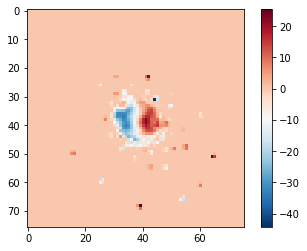

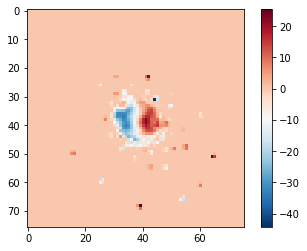

In [5]:
# Verify that this is done correctly

#print(map_ml_all_stel[0])
#print(map_ml_stel_vel[0])


test_n = 1

reconstruct_stel_vel = np.reshape(map_ml_all_stel[test_n,:length_cube], (shape, shape))

plt.clf()
plt.imshow(reconstruct_stel_vel, cmap='RdBu_r')
plt.colorbar()
plt.show()

plt.clf()
plt.imshow(np.reshape(map_ml_stel_vel[test_n,:], (shape, shape)), cmap='RdBu_r')
plt.colorbar()
plt.show()

### The problem:
The problem is that this data is not coherent, we need a way to treat the two maps as overlapping pictures and not treat all of the pixels separately.

<Figure size 432x288 with 0 Axes>

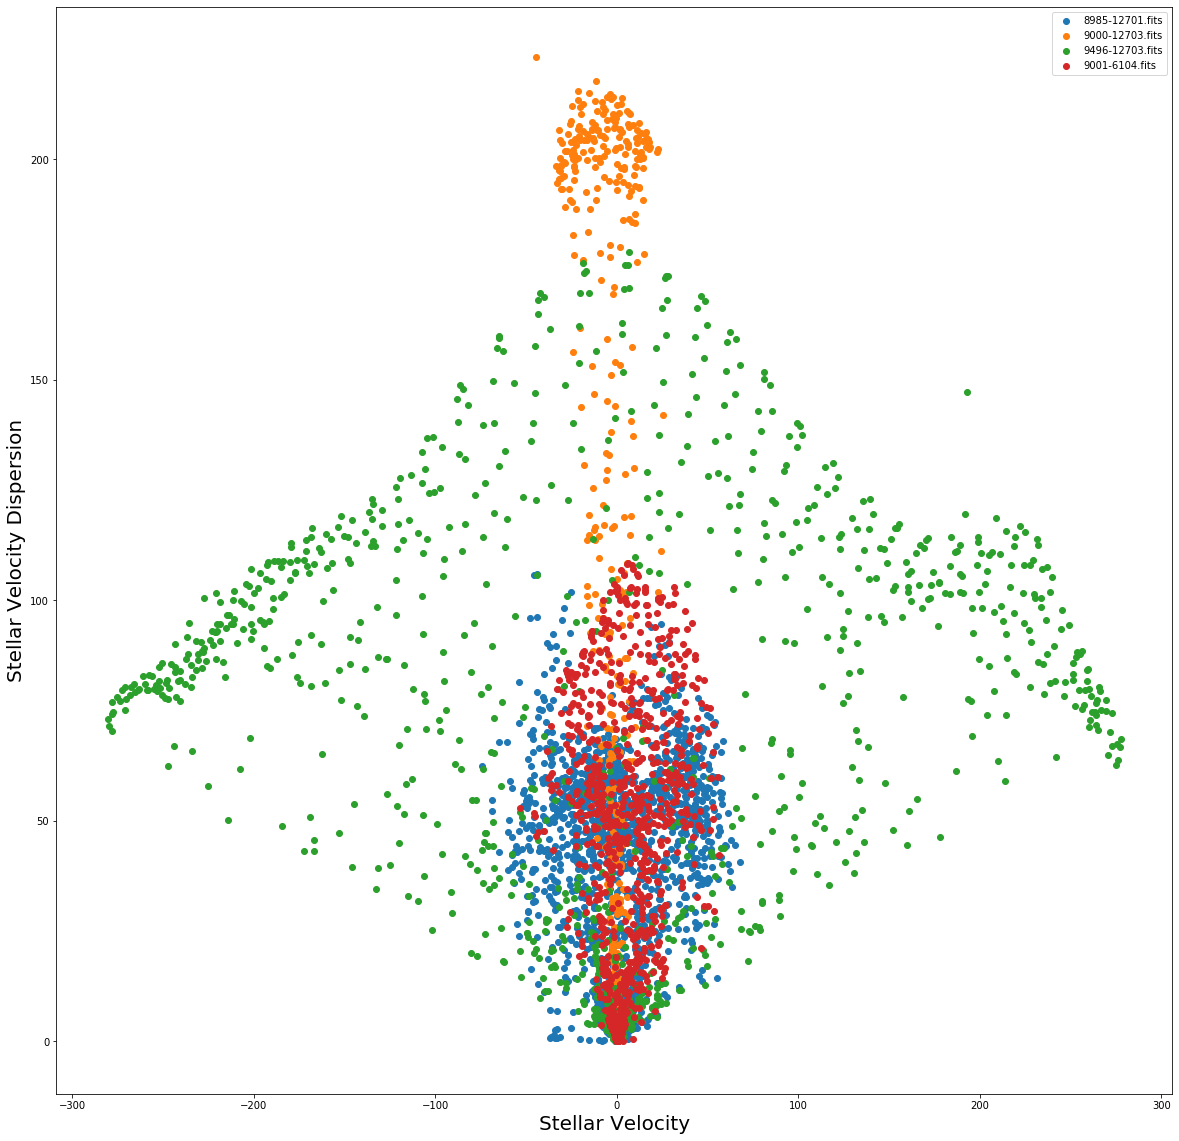

In [6]:
# It is still interesting to look at all of the data points individually:
plt.clf()
fig = plt.figure(figsize=(20,20))
for j in range(4):#len(plates)):
    plt.scatter(map_ml_stel_vel[j], map_ml_stel_disp[j], label=str(plates[j]))
plt.legend()
plt.xlabel('Stellar Velocity', size=20)
plt.ylabel('Stellar Velocity Dispersion', size=20)
plt.show()

check 1 False
check 2 True
(85, 5776)
[1 1 3 1 0 0 1 1 1 1 1 1 0 1 4 1 3 0 1 1 4 1 0 0 1 1 3 1 1 4 1 3 5 1 1 1 1
 1 2 1 1 1 1 4 0 1 1 1 4 4 0 4 5 0 1 4 0 3 1 4 0 1 4 1 1 1 4 1 4 4 3 1 1 4
 1 4 1 3 0 1 1 1 0 1 1]
(6, 5776)


<Figure size 432x288 with 0 Axes>

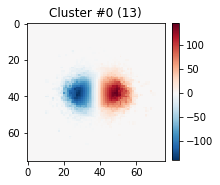

(76, 76)
This is the number of galaxies in this cluster 13


<Figure size 432x288 with 0 Axes>

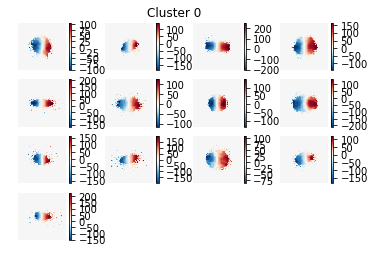

<Figure size 432x288 with 0 Axes>

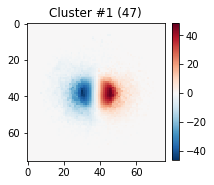

This is the number of galaxies in this cluster 47


<Figure size 432x288 with 0 Axes>

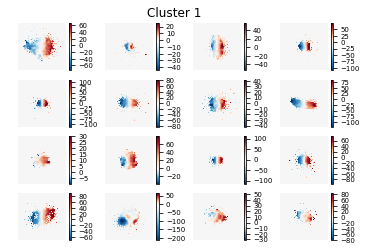

<Figure size 432x288 with 0 Axes>

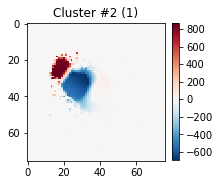

<Figure size 432x288 with 0 Axes>

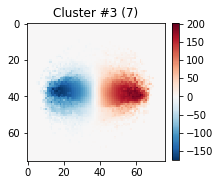

This is the number of galaxies in this cluster 7


<Figure size 432x288 with 0 Axes>

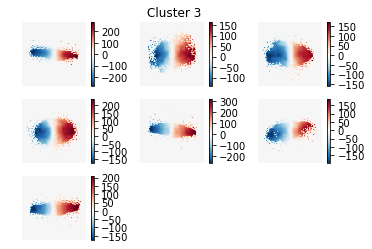

<Figure size 432x288 with 0 Axes>

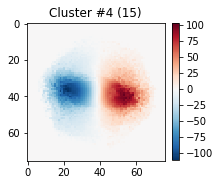

This is the number of galaxies in this cluster 15


<Figure size 432x288 with 0 Axes>

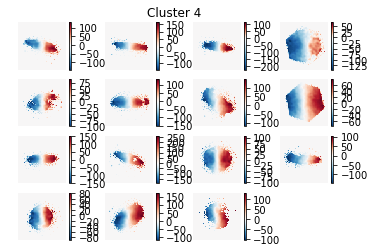

<Figure size 432x288 with 0 Axes>

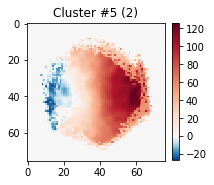

This is the number of galaxies in this cluster 2


<Figure size 432x288 with 0 Axes>

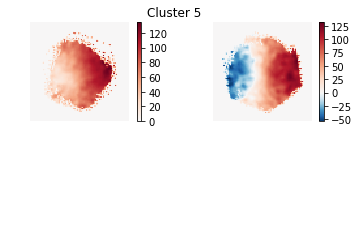

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:142: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


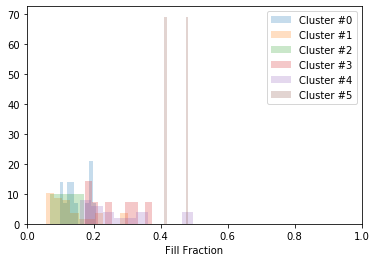

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


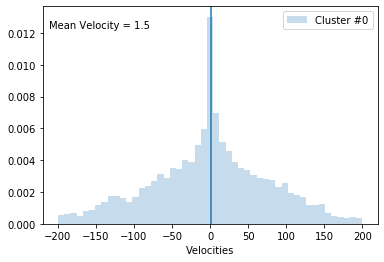

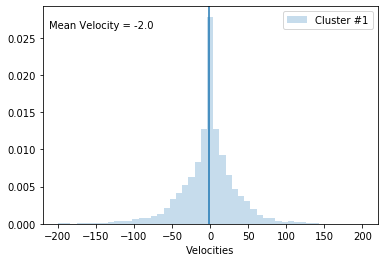

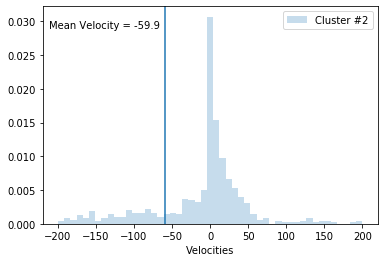

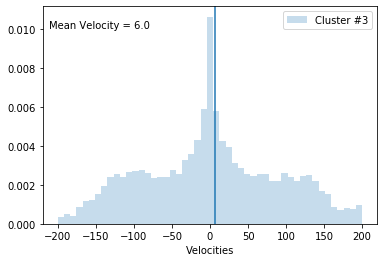

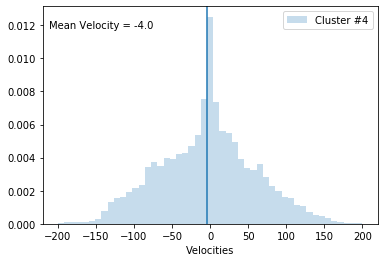

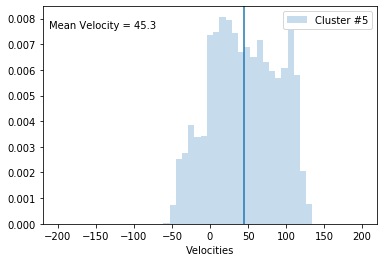

In [59]:
# The initial problem with clustering is that when you go from 2 to 3 clusters, there are galaxies
# that occupy clusters by themselves, so I would like to remove them from the sample
# at least so they're not part of the clustering

#no_zeros = np.ma.masked_where(map_ml_all_stel==0, map_ml_all_stel)
no_inf = np.ma.masked_where(np.isinf(map_ml_stel_vel), map_ml_stel_vel)
no_nan = np.ma.masked_where(np.isnan(no_inf), no_inf)

data_cluster = no_nan.filled()

shape = int(np.sqrt(length_cube))


'''for j in range(10):
    print(data_cluster)
'''

#np.isfinite(X).all()

print('check 1', np.any(np.isnan(data_cluster))) # you want this to be False
print('check 2', np.all(np.isfinite(data_cluster))) # and this to be true


#np.ma.masked_where(np.isnan(map_ml_all_stel), map_ml_all_stel)
#print(data_cluster[len(plates)-1])


from sklearn.cluster import KMeans
nclusters=6
kmeans = KMeans(n_clusters=nclusters, random_state=0)
print(np.shape(data_cluster))
clusters = kmeans.fit_predict(data_cluster)
print(clusters)
print(np.shape(kmeans.cluster_centers_))
centers = kmeans.cluster_centers_.reshape(nclusters, shape, shape)

# These are meant to be repopulated every time you cut the galaxies
bad_galaxies = np.zeros(np.shape(data_ml_2d_vel))
bad_galaxies_ifus = []
fill_frac_list = {}
vel_list = {}

counter=0

for i in range(nclusters):
    plt.clf()
    fig = plt.figure()
    ax0 = fig.add_subplot(121)
    im0 = ax0.imshow(centers[i], cmap='RdBu_r',norm=MidpointNormalize(midpoint=0))#, vmin=-100, vmax=100)
    plt.colorbar(im0, fraction=0.045)
    plt.title('Cluster #'+str(i)+' ('+str(np.shape(cluster[i])[0])+')')
    plt.show()
    
    cluster={}
    ifu={}
    #cluster_name=[]
    for n in range(nclusters):

        cluster[n]=[]
        ifu[n]=[]
        #cluster_d[n]=[]
        for j in range(np.shape(data_ml_2d_vel)[0]):
            if clusters[j]==n:
                cluster[n].append(np.reshape(data_ml_2d_vel[j,:],(shape,shape)))
                ifu[n].append(existing_plateifus[j])
        #cluster_name.append(str(cluster[n]))
        if len(ifu[n])==1:
            if ifu[n] in bad_galaxies_ifus:
                continue
            bad_galaxies_ifus.append(ifu[n])
            #bad_galaxies_ifus_master.append(ifu[n])
            print(np.shape(cluster[n][0]))
            bad_galaxies[counter,:,:] = cluster[n][0]
            #bad_galaxies_master[counter_master,:,:] = cluster[n][0]
            counter+=1
            #counter_master+=1
    nclusters_list = np.arange(0,nclusters)
    # Now run some statistics of each cluster
    # Like how many spaxels are in the cluster on average
    fill_frac_list[i] = []
    vel_list[i] = []
    full = np.shape(centers[i])[0]**2
    for j in range(np.shape(cluster[i])[0]):
        fill = np.count_nonzero(cluster[i][j])/full
        fill_frac_list[i].append(fill)
        
        flat = cluster[i][j].flatten()
        list_vel = flat[np.nonzero(flat)]
        for p in range(len(list_vel)):
            vel_list[i].append(list_vel[p])
    
    if np.shape(cluster[i])[0] ==1:
        continue
    plt.clf()
    fig=plt.figure()
    #fig.subplots_adjust(hspace = .5, wspace=.001)
    plt.title('Cluster '+str(i))
    plt.axis('off')
    print('This is the number of galaxies in this cluster '+str(np.shape(cluster[i])[0]))
    if np.shape(cluster[i])[0] < 16:
            if np.shape(cluster[i])[0] < 9:
                if np.shape(cluster[i])[0] < 4:
                    for j in range(np.shape(cluster[i])[0]):
                        ax = fig.add_subplot(2,2,j+1)
                        im = ax.imshow(cluster[i][j], cmap='RdBu_r', norm=MidpointNormalize(midpoint=0))#, vmin=-100, vmax=100)
                        plt.colorbar(im)
                        ax.axis('off')
                    plt.show()

                else:
                    for j in range(np.shape(cluster[i])[0]):
                        ax = fig.add_subplot(3,3,j+1)
                        im = ax.imshow(cluster[i][j], cmap='RdBu_r', norm=MidpointNormalize(midpoint=0))#, vmin=-100, vmax=100)
                        plt.colorbar(im)
                        ax.axis('off')
                    plt.show()
            else:
                for j in range(np.shape(cluster[i])[0]):
                    ax = fig.add_subplot(4,4,j+1)
                    im = ax.imshow(cluster[i][j], cmap='RdBu_r', norm=MidpointNormalize(midpoint=0))#, vmin=-100, vmax=100)
                    plt.colorbar(im)
                    ax.axis('off')
                plt.show()
    else:
        for j in range(16):
            ax = fig.add_subplot(4,4,j+1)
            im = ax.imshow(cluster[i][j], cmap='RdBu_r', norm=MidpointNormalize(midpoint=0))#, vmin=-100, vmax=100)
            cbar = plt.colorbar(im)
            cbar.ax.tick_params(labelsize=7) 
            ax.axis('off')
        plt.show()
        
    

    # Okay so if there's only one object in a cluster delete that object and add it to 'bad list'
    
# plot fill fraction
plt.clf()
for j in range(len(fill_frac_list)):
    #print('fill frac cluster '+str(j))
    #print(fill_frac_list[j])
    plt.hist(fill_frac_list[j], label='Cluster #'+str(j), alpha=0.25, normed=True)
plt.legend()
plt.xlim([0,1])
plt.xlabel('Fill Fraction')
plt.show()

# plot velocities
binwidth = 50

for j in range(len(fill_frac_list)):
    #print(vel_list[j])
    plt.clf()
    
    plt.hist(vel_list[j], label='Cluster #'+str(j), alpha=0.25, bins=np.linspace(-200, 200, binwidth), normed=True)
    plt.legend()
    plt.xlabel('Velocities')
    plt.axvline(x = np.mean(vel_list[j]))
    plt.annotate('Mean Velocity = '+str(round(np.mean(vel_list[j]),1)), xy = (0.02, 0.9), xycoords='axes fraction')
    #plt.xlim([0,1])
    plt.show()

### See if using PCA with clustering will help
Aka try clustering instead on the PCA components?

In [65]:
MB_matrix = data_cluster

# Covariance
np.set_printoptions(precision=3)
cov = np.cov(MB_matrix)#.transpose())
# Eigen Values
EigVal,EigVec = np.linalg.eig(cov)
print("Eigenvalues:\n\n", EigVal,"\n")

Eigenvalues:

 [ 3.811e+38+0.000e+00j  2.679e+38+0.000e+00j  1.530e+38+0.000e+00j
  1.446e+38+0.000e+00j  1.342e+38+0.000e+00j  1.183e+38+0.000e+00j
  1.032e+38+0.000e+00j  9.976e+37+0.000e+00j  7.752e+37+0.000e+00j
  7.344e+37+0.000e+00j  7.097e+37+0.000e+00j  5.499e+37+0.000e+00j
  5.178e+37+0.000e+00j  5.231e+37+0.000e+00j  4.222e+37+0.000e+00j
  3.967e+37+0.000e+00j  3.871e+37+0.000e+00j  3.440e+37+0.000e+00j
  3.534e+37+0.000e+00j  2.519e+37+0.000e+00j  2.293e+37+0.000e+00j
  2.196e+37+0.000e+00j  2.245e+37+0.000e+00j  2.058e+37+0.000e+00j
  1.364e+37+0.000e+00j  1.505e+37+0.000e+00j  9.605e+36+0.000e+00j
  1.467e+37+0.000e+00j  1.486e+37+0.000e+00j  8.649e+36+0.000e+00j
  6.732e+36+0.000e+00j  6.423e+36+0.000e+00j  6.467e+36+0.000e+00j
  6.907e+36+0.000e+00j  6.921e+36+0.000e+00j  6.926e+36+0.000e+00j
  1.587e+21+0.000e+00j -1.342e+21+0.000e+00j -3.329e+20+5.229e+20j
 -3.329e+20-5.229e+20j -3.283e+20+0.000e+00j  4.255e+20+0.000e+00j
  2.166e+20+9.320e+19j  2.166e+20-9.320e+19j  2

[0 1 2 3 4 5 6 7 8 9]
eigval [3.811e+38+0.j 2.679e+38+0.j 1.530e+38+0.j 1.446e+38+0.j 1.342e+38+0.j
 1.183e+38+0.j 1.032e+38+0.j 9.976e+37+0.j 7.752e+37+0.j 7.344e+37+0.j]


/Users/beckynevin/anaconda3/lib/python3.7/site-packages/matplotlib/transforms.py:796: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)


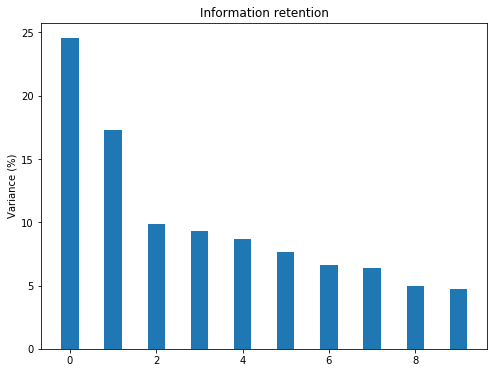

In [66]:
# Ordering Eigen values and vectors
n_PCAs = 10
order = EigVal.argsort()[::-1][:n_PCAs]
EigVal = EigVal[order]
EigVec = EigVec[:,order]
#Projecting data on Eigen vector directions resulting to Principal Components 
PC = np.matmul(MB_matrix.transpose(),EigVec)   #cross product

print(order)
print('eigval', EigVal)

#Information Retained by Principal Components
plt.figure(figsize=(8,6))
plt.bar(range(n_PCAs),EigVal/sum(EigVal)*100,align='center',width=0.4)
plt.ylabel('Variance (%)')
plt.title('Information retention');

(5776, 10)


/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  


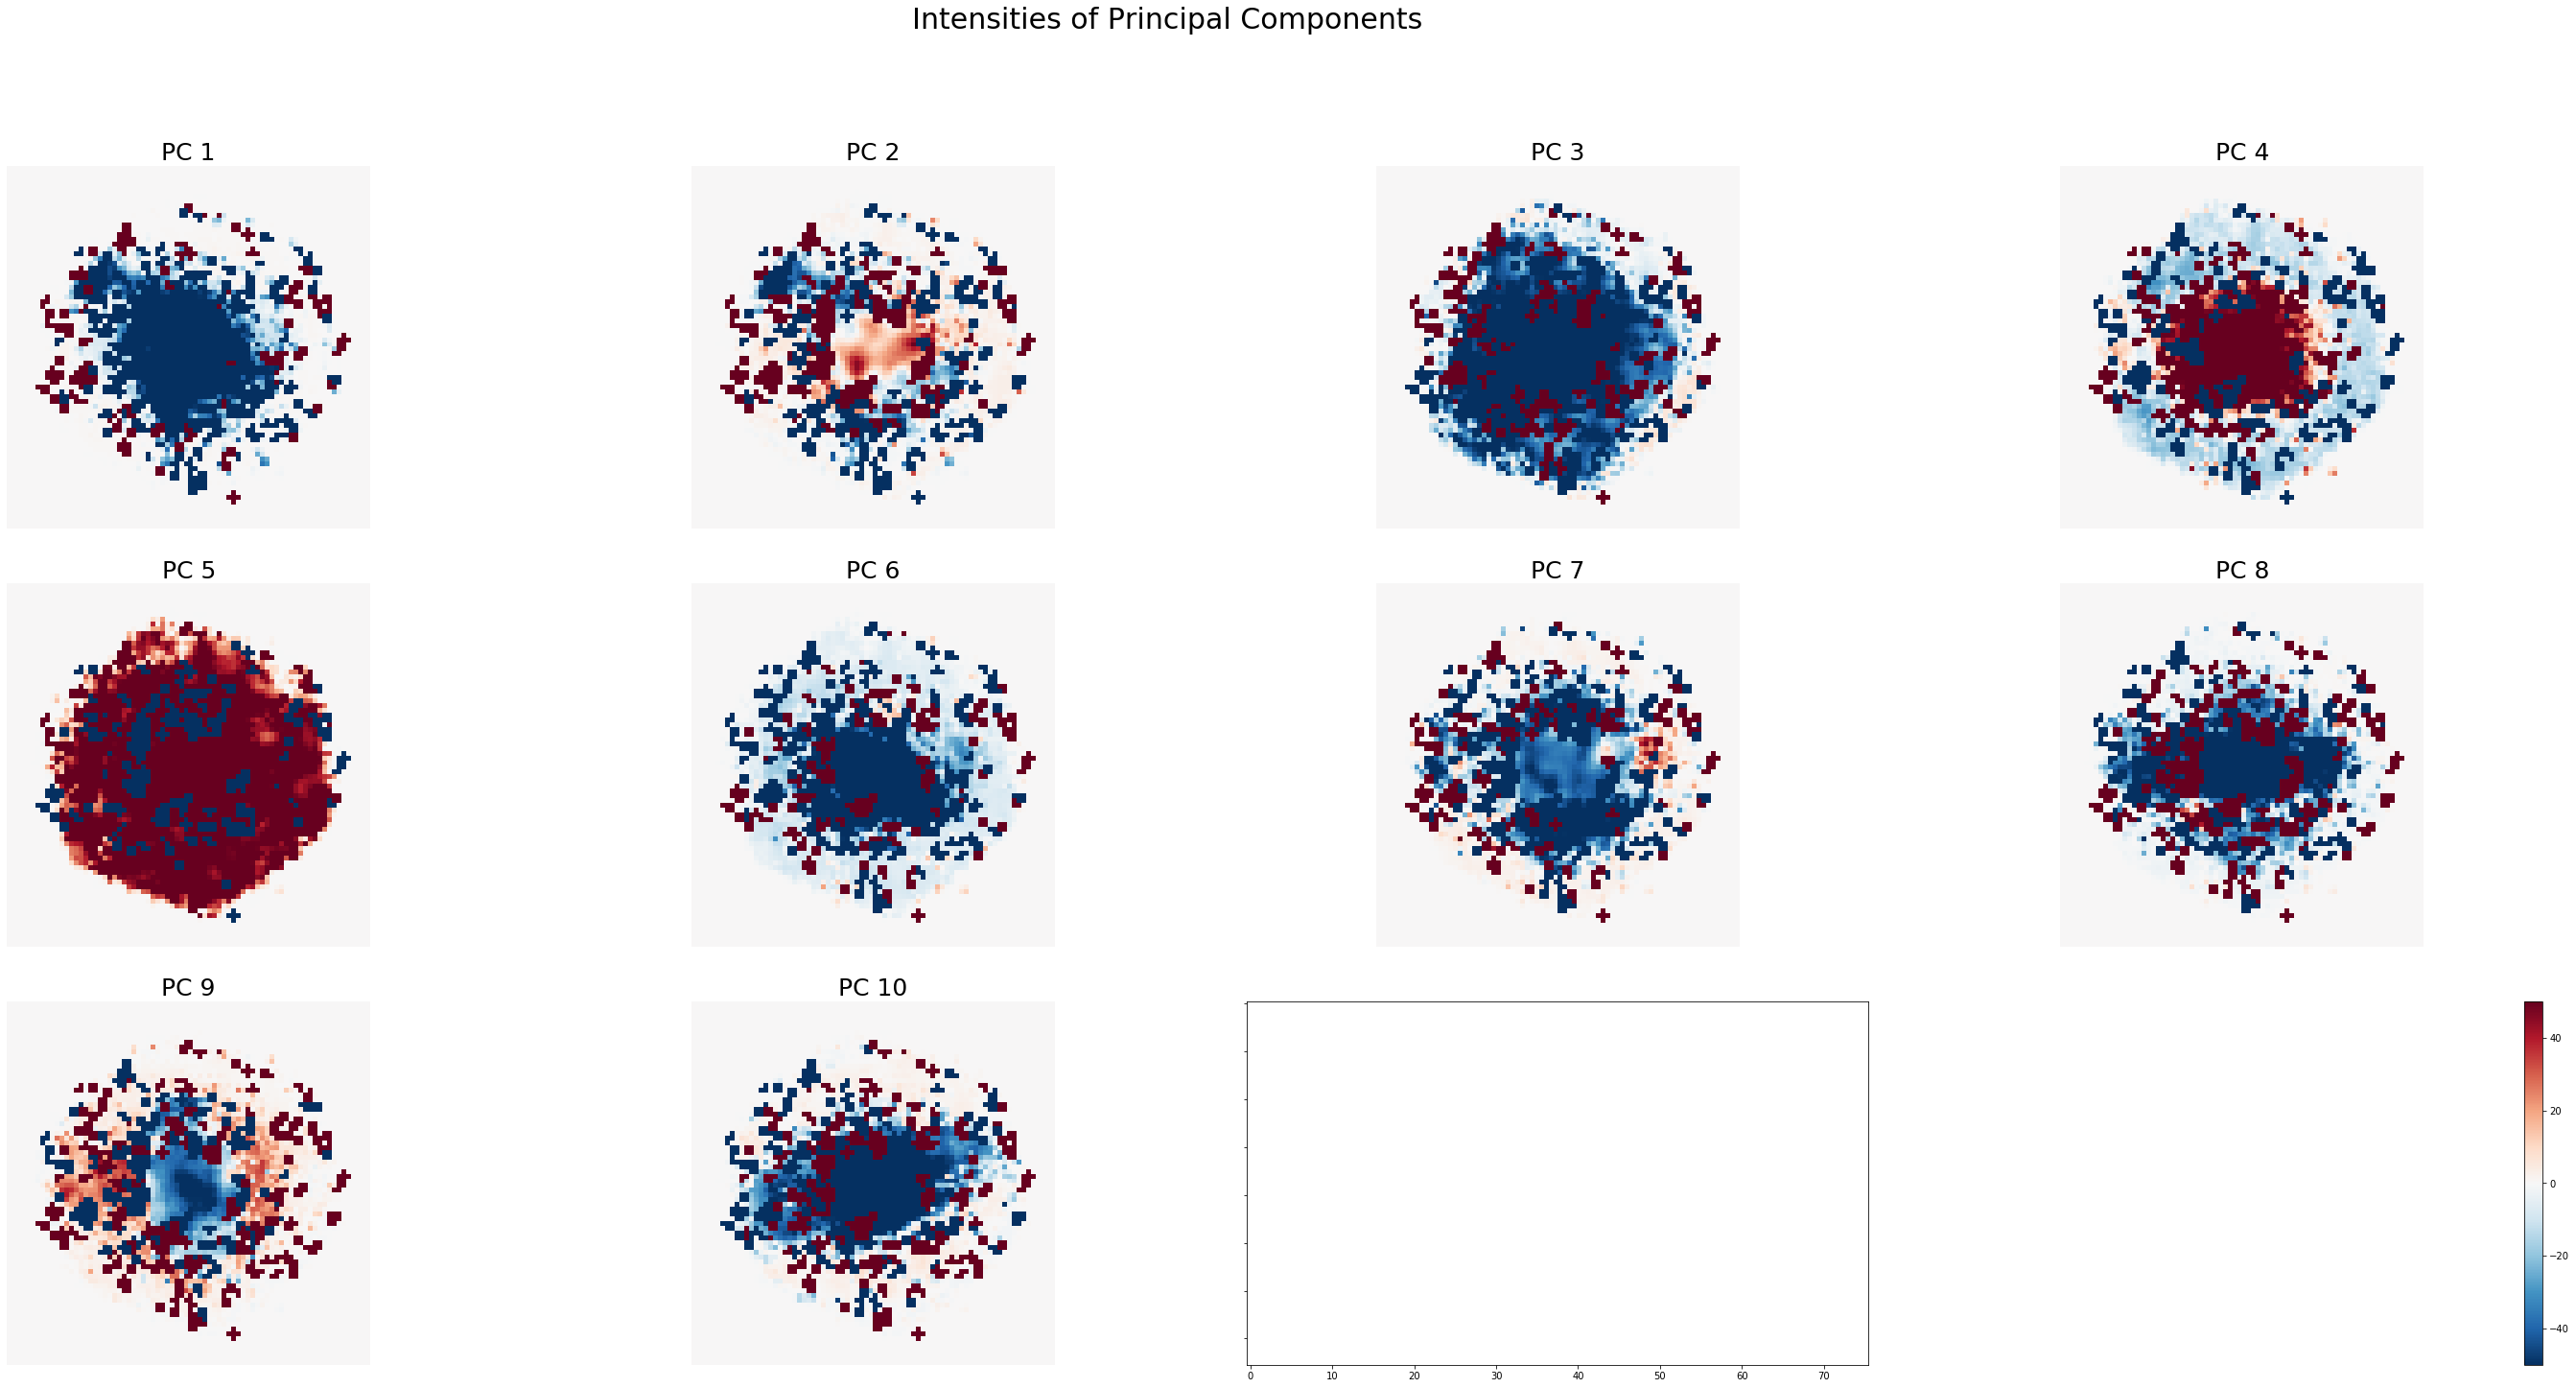

In [69]:
# Rearranging 1-d arrays to 2-d arrays of image size
print(np.shape(PC))


n_galaxies = np.shape(MB_matrix)[0]
PC_2d = np.zeros((n_galaxies, shape, shape))
for i in range(n_PCAs):
    PC_2d[i,:,:] = PC[:,i].reshape(-1,shape)
# normalizing between 0 to 255
'''PC_2d_Norm = np.zeros((n_galaxies, shape, shape))
for i in range(n_bands):
    PC_2d_Norm[i,:,:] = cv2.normalize(PC_2d[i,:,:],
                    np.zeros((shape,shape)),0,255 ,cv2.NORM_MINMAX)'''

fig,axes = plt.subplots(3,4,figsize=(50,23),sharex='all',
                        sharey='all')
fig.subplots_adjust(wspace=0.1, hspace=0.15)
fig.suptitle('Intensities of Principal Components ', fontsize=30)
axes = axes.ravel()
for i in range(n_PCAs):
    
    im = axes[i].imshow(PC_2d[i,:,:],cmap='RdBu_r', vmin=-50, vmax=50)
    axes[i].set_title('PC '+str(i+1),fontsize=25)
    axes[i].axis('off')
    
plt.colorbar(im, fraction=0.046)
fig.delaxes(axes[-1])

In [70]:
from sklearn.decomposition import PCA as RandomizedPCA
# Compute the components and projected faces
n_PCA = 50
pca = RandomizedPCA(n_PCA).fit(MB_matrix)
components = pca.transform(MB_matrix)
projected = pca.inverse_transform(components)

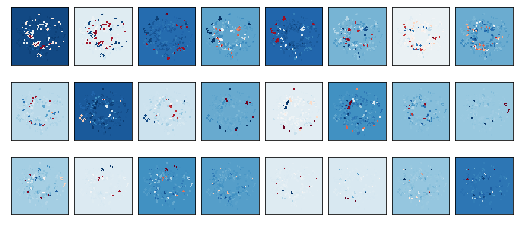

In [71]:
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(shape,shape), cmap='RdBu_r')

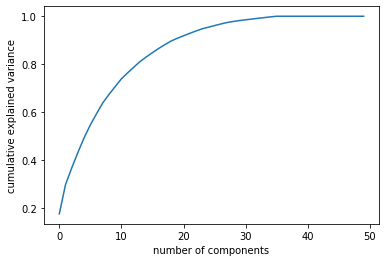

In [72]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

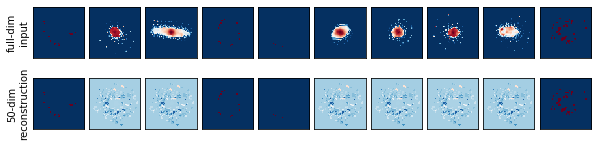

In [73]:
# Plot the results
fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(MB_matrix[i].reshape(shape,shape), cmap='RdBu_r')
    ax[1, i].imshow(projected[i].reshape(shape,shape), cmap='RdBu_r')
    
ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel(str(n_PCA)+'-dim\nreconstruction');

check 1 False
check 2 True
(85, 5776)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0]
(3, 5776)


<Figure size 432x288 with 0 Axes>

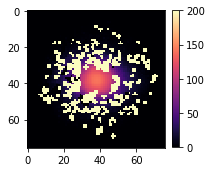

(76, 76)
(76, 76)
This is the number of galaxies in this cluster 83


<Figure size 432x288 with 0 Axes>

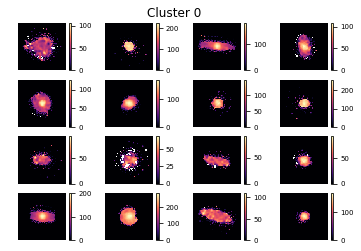

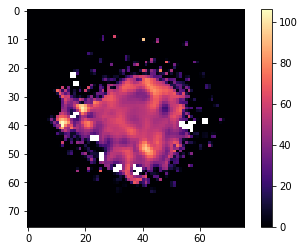

NameError: name 'STOP' is not defined

In [64]:
# Do the same but for stellar velocity dispersion
no_inf = np.ma.masked_where(np.isinf(map_ml_stel_disp), map_ml_stel_disp)
no_nan = np.ma.masked_where(np.isnan(no_inf), no_inf)

data_cluster = no_nan.filled()

shape = int(np.sqrt(length_cube))


'''for j in range(10):
    print(data_cluster)
'''

#np.isfinite(X).all()

print('check 1', np.any(np.isnan(data_cluster))) # you want this to be False
print('check 2', np.all(np.isfinite(data_cluster))) # and this to be true


#np.ma.masked_where(np.isnan(map_ml_all_stel), map_ml_all_stel)
#print(data_cluster[len(plates)-1])


from sklearn.cluster import KMeans
nclusters=3
kmeans = KMeans(n_clusters=nclusters, random_state=0)
print(np.shape(data_cluster))
clusters = kmeans.fit_predict(data_cluster)
print(clusters)
print(np.shape(kmeans.cluster_centers_))
centers_disp = kmeans.cluster_centers_.reshape(nclusters, shape, shape)

# These are meant to be repopulated every time you cut the galaxies
bad_galaxies = np.zeros(np.shape(data_ml_2d_vel))
bad_galaxies_ifus = []

counter=0

for i in range(nclusters):
    plt.clf()
    fig = plt.figure()
    ax1 = fig.add_subplot(122)
    im1 = ax1.imshow(centers_disp[i], cmap='magma', vmin=0, vmax=200)
    plt.colorbar(im1, fraction=0.045)
    ax0.set_title('Cluster '+str(i)+' Center')
    
    plt.show()
    
    cluster={}
    cluster_d={}
    ifu={}
    #cluster_name=[]
    for n in range(nclusters):

        cluster[n]=[]
        ifu[n]=[]
        cluster_d[n]=[]
        for j in range(np.shape(data_ml_2d_vel)[0]):
            if clusters[j]==n:
                cluster[n].append(np.reshape(data_ml_2d_vel[j,:],(shape,shape)))
                cluster_d[n].append(np.reshape(data_ml_2d_disp[j,:],(shape,shape)))
                ifu[n].append(existing_plateifus[j])
        #cluster_name.append(str(cluster[n]))
        if len(ifu[n])==1:
            if ifu[n] in bad_galaxies_ifus:
                continue
            bad_galaxies_ifus.append(ifu[n])
            #bad_galaxies_ifus_master.append(ifu[n])
            print(np.shape(cluster[n][0]))
            bad_galaxies[counter,:,:] = cluster[n][0]
            #bad_galaxies_master[counter_master,:,:] = cluster[n][0]
            counter+=1
            #counter_master+=1
    nclusters_list = np.arange(0,nclusters)
    
    
        
        
    # Do the same but for the velocity dispersion maps
    plt.clf()
    fig=plt.figure()
    #fig.subplots_adjust(hspace = .5, wspace=.001)
    plt.title('Cluster '+str(i))
    plt.axis('off')
    print('This is the number of galaxies in this cluster '+str(np.shape(cluster[i])[0]))
    if np.shape(cluster[i])[0] < 16:
            if np.shape(cluster[i])[0] < 9:
                if np.shape(cluster[i])[0] < 4:
                    for j in range(np.shape(cluster[i])[0]):
                        ax = fig.add_subplot(2,2,j+1)
                        im = ax.imshow(cluster_d[i][j], cmap='magma')#, vmin=-100, vmax=100)
                        plt.colorbar(im)
                        ax.axis('off')
                    plt.show()

                else:
                    for j in range(np.shape(cluster[i])[0]):
                        ax = fig.add_subplot(3,3,j+1)
                        im = ax.imshow(cluster_d[i][j], cmap='magma')#, vmin=-100, vmax=100)
                        plt.colorbar(im)
                        ax.axis('off')
                    plt.show()
            else:
                for j in range(np.shape(cluster[i])[0]):
                    ax = fig.add_subplot(4,4,j+1)
                    im = ax.imshow(cluster_d[i][j], cmap='magma')#, vmin=-100, vmax=100)
                    plt.colorbar(im)
                    ax.axis('off')
                plt.show()
    else:
        for j in range(16):
            ax = fig.add_subplot(4,4,j+1)
            im = ax.imshow(cluster_d[i][j], cmap='magma')#, vmin=-100, vmax=100)
            cbar = plt.colorbar(im)
            cbar.ax.tick_params(labelsize=7) 
            ax.axis('off')
        plt.show()
    # Okay so if there's only one object in a cluster delete that object and add it to 'bad list'
    
    plt.clf()
    plt.imshow(cluster_d[i][0], cmap='magma')
    plt.colorbar()
    plt.show()
    STOP
 

check 1 False
check 2 True
(85, 11552)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0]
(3, 11552)


<Figure size 432x288 with 0 Axes>

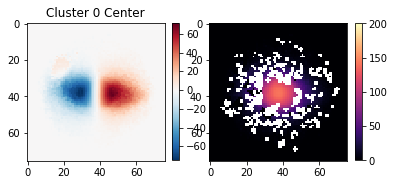

what is the difference between these clusters
[[ 7.62835511  4.93424364  0.73499557 ...  2.37477355  3.04791009
   2.4032979 ]
 [ 6.33184152  7.18735088  7.08930454 ...  2.23300286  2.14318824
   1.94295153]
 [ 6.01291432  4.99604227  6.46336312 ...  2.71507711  1.24789161
   3.10930242]
 ...
 [-2.14656454 -3.76622552 -3.19071312 ...  1.24422465  0.91816335
   0.5620408 ]
 [-1.6384472  -2.59991618 -2.69720922 ...  1.57405027  1.36795391
   0.26104864]
 [-1.35429764 -2.2676122  -2.02355938 ...  0.88515157  0.07722141
   0.        ]]
[[-1.02400000e+03  4.06873129e+00  3.89069200e+00 ...  2.07705820e+00
   2.04905650e+00  1.57987987e+00]
 [-1.02400000e+03  5.30579655e+00  4.32013105e+00 ...  2.13676127e+00
   1.96085979e+00  1.45630246e+00]
 [-1.02400000e+03  8.29480687e+00  5.70056273e+00 ...  2.32998724e+00
   1.60155643e+00  1.97834102e+00]
 ...
 [ 3.88088417e+00  5.16526707e+00  3.73502986e+00 ...  1.83892030e+00
   2.21152118e+00  1.20481928e+18]
 [ 2.80234617e+00  4.49461393e+00  3.

NameError: name 'STOP' is not defined

In [103]:
# The initial problem with clustering is that when you go from 2 to 3 clusters, there are galaxies
# that occupy clusters by themselves, so I would like to remove them from the sample
# at least so they're not part of the clustering

#no_zeros = np.ma.masked_where(map_ml_all_stel==0, map_ml_all_stel)
no_inf = np.ma.masked_where(np.isinf(map_ml_all_stel), map_ml_all_stel)
no_nan = np.ma.masked_where(np.isnan(no_inf), no_inf)

data_cluster = no_nan.filled()

shape = int(np.sqrt(length_cube))


'''for j in range(10):
    print(data_cluster)
'''

#np.isfinite(X).all()

print('check 1', np.any(np.isnan(data_cluster))) # you want this to be False
print('check 2', np.all(np.isfinite(data_cluster))) # and this to be true


#np.ma.masked_where(np.isnan(map_ml_all_stel), map_ml_all_stel)
#print(data_cluster[len(plates)-1])


from sklearn.cluster import KMeans
nclusters=3
kmeans = KMeans(n_clusters=nclusters, random_state=0)
print(np.shape(data_cluster))
clusters = kmeans.fit_predict(data_cluster)
print(clusters)
print(np.shape(kmeans.cluster_centers_))
centers = kmeans.cluster_centers_[:,:length_cube].reshape(nclusters, shape, shape)
centers_disp = kmeans.cluster_centers_[:,length_cube:].reshape(nclusters, shape, shape)

# These are meant to be repopulated every time you cut the galaxies
bad_galaxies = np.zeros(np.shape(data_ml_2d_vel))
bad_galaxies_ifus = []

counter=0

for i in range(nclusters):
    plt.clf()
    fig = plt.figure()
    ax0 = fig.add_subplot(121)
    im0 = ax0.imshow(centers[i], cmap='RdBu_r',norm=MidpointNormalize(midpoint=0))#, vmin=-100, vmax=100)
    plt.colorbar(im0, fraction=0.045)
    ax1 = fig.add_subplot(122)
    im1 = ax1.imshow(np.ma.masked_where(centers_disp[i] > 1e6, centers_disp[i]), cmap='magma', vmin=0, vmax=200)
    plt.colorbar(im1, fraction=0.045)
    ax0.set_title('Cluster '+str(i)+' Center')
    plt.show()
    
    print('what is the difference between these clusters')
    print(centers[i][20:60,20:60])
    print(centers_disp[i][20:60,20:60])
    STOP
    
    cluster={}
    cluster_d={}
    ifu={}
    #cluster_name=[]
    for n in range(nclusters):

        cluster[n]=[]
        ifu[n]=[]
        cluster_d[n]=[]
        for j in range(np.shape(data_ml_2d_vel)[0]):
            if clusters[j]==n:
                cluster[n].append(np.reshape(data_ml_2d_vel[j,:],(shape,shape)))
                cluster_d[n].append(np.reshape(data_ml_2d_disp[j,:],(shape,shape)))
                ifu[n].append(existing_plateifus[j])
        #cluster_name.append(str(cluster[n]))
        if len(ifu[n])==1:
            if ifu[n] in bad_galaxies_ifus:
                continue
            bad_galaxies_ifus.append(ifu[n])
            #bad_galaxies_ifus_master.append(ifu[n])
            print(np.shape(cluster[n][0]))
            bad_galaxies[counter,:,:] = cluster[n][0]
            #bad_galaxies_master[counter_master,:,:] = cluster[n][0]
            counter+=1
            #counter_master+=1
    nclusters_list = np.arange(0,nclusters)
    
    plt.clf()
    fig=plt.figure()
    #fig.subplots_adjust(hspace = .5, wspace=.001)
    plt.title('Cluster '+str(i))
    plt.axis('off')
    print('This is the number of galaxies in this cluster '+str(np.shape(cluster[i])[0]))
    if np.shape(cluster[i])[0] < 16:
            if np.shape(cluster[i])[0] < 9:
                if np.shape(cluster[i])[0] < 4:
                    for j in range(np.shape(cluster[i])[0]):
                        ax = fig.add_subplot(2,2,j+1)
                        im = ax.imshow(cluster[i][j], cmap='RdBu_r', norm=MidpointNormalize(midpoint=0))#, vmin=-100, vmax=100)
                        plt.colorbar(im)
                        ax.axis('off')
                    plt.show()

                else:
                    for j in range(np.shape(cluster[i])[0]):
                        ax = fig.add_subplot(3,3,j+1)
                        im = ax.imshow(cluster[i][j], cmap='RdBu_r', norm=MidpointNormalize(midpoint=0))#, vmin=-100, vmax=100)
                        plt.colorbar(im)
                        ax.axis('off')
                    plt.show()
            else:
                for j in range(np.shape(cluster[i])[0]):
                    ax = fig.add_subplot(4,4,j+1)
                    im = ax.imshow(cluster[i][j], cmap='RdBu_r', norm=MidpointNormalize(midpoint=0))#, vmin=-100, vmax=100)
                    plt.colorbar(im)
                    ax.axis('off')
                plt.show()
    else:
        for j in range(16):
            ax = fig.add_subplot(4,4,j+1)
            im = ax.imshow(cluster[i][j], cmap='RdBu_r', norm=MidpointNormalize(midpoint=0))#, vmin=-100, vmax=100)
            cbar = plt.colorbar(im)
            cbar.ax.tick_params(labelsize=7) 
            ax.axis('off')
        plt.show()
        
        
    # Do the same but for the velocity dispersion maps
    plt.clf()
    fig=plt.figure()
    #fig.subplots_adjust(hspace = .5, wspace=.001)
    plt.title('Cluster '+str(i))
    plt.axis('off')
    print('This is the number of galaxies in this cluster '+str(np.shape(cluster[i])[0]))
    if np.shape(cluster[i])[0] < 16:
            if np.shape(cluster[i])[0] < 9:
                if np.shape(cluster[i])[0] < 4:
                    for j in range(np.shape(cluster[i])[0]):
                        ax = fig.add_subplot(2,2,j+1)
                        im = ax.imshow(cluster_d[i][j], cmap='magma')#, vmin=-100, vmax=100)
                        plt.colorbar(im)
                        ax.axis('off')
                    plt.show()

                else:
                    for j in range(np.shape(cluster[i])[0]):
                        ax = fig.add_subplot(3,3,j+1)
                        im = ax.imshow(cluster_d[i][j], cmap='magma')#, vmin=-100, vmax=100)
                        plt.colorbar(im)
                        ax.axis('off')
                    plt.show()
            else:
                for j in range(np.shape(cluster[i])[0]):
                    ax = fig.add_subplot(4,4,j+1)
                    im = ax.imshow(cluster_d[i][j], cmap='magma')#, vmin=-100, vmax=100)
                    plt.colorbar(im)
                    ax.axis('off')
                plt.show()
    else:
        for j in range(16):
            ax = fig.add_subplot(4,4,j+1)
            im = ax.imshow(cluster_d[i][j], cmap='magma')#, vmin=-100, vmax=100)
            cbar = plt.colorbar(im)
            cbar.ax.tick_params(labelsize=7) 
            ax.axis('off')
        plt.show()
    # Okay so if there's only one object in a cluster delete that object and add it to 'bad list'
    
 